<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/main/templates/waveform-extraction-starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/main/templates/waveform-extraction-starter.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>


‼️ **Prerequisites** ‼️:
- Access to the `Nucleonics` Google drive folder (it must also be added as a shortcut called "Nucleonics" in your own drive)
- Access to the nucleonics `.env` folder (where sensitive info lives)

# Waveform extraction

This notebook contains starter code that extracts and visualises event waveforms from a ROOT file.

## Libraries

In [ ]:
# Auth
import sys, os
import shutil
from google.colab import drive
from google.colab import auth
from google.auth import default

# Files
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io
import os
import gspread

# Data analysis
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sqlalchemy import create_engine, text
from scipy.stats import kstest
! pip install uproot -q
import uproot

#Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go

## Authentication

In [ ]:
# Mount Drive
drive.mount('/content/drive')

# Authenticate and create the Drive API client
auth.authenticate_user()
drive_service = build('drive', 'v3')
creds, _ = default()
gc = gspread.authorize(creds)

# Copy SQL credentials from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/psql_credentials_readonly.py", "psql_credentials.py")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'psql_credentials.py'

In [ ]:
# Import SQL credentials
from psql_credentials import PGUSER, PGPASSWORD, PGHOST, PGPORT, PGDATABASE

# Create the database connection string
connection_uri = f'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}'
engine = create_engine(connection_uri)

## Fetch the ROOT file corresponding to the a time period

For this notebook we must specify a:
- channel number
- time of interest
- duration around the time of interest

In [ ]:
channel_number = 6
time = '2025-09-03 12:00:00'
duration = 600

We now look in the database for the closest ROOT file to the `time`. Since our ROOT files are organised by their end time (time of the last event), we need to look for the closest ROOT file after our specified `time`.

In [ ]:
def find_root_file(event_time, channel_number):
    query = """
    SELECT *
    FROM root_files
    WHERE time > %(event_time)s
      AND file LIKE %(file_pattern)s
    ORDER BY ABS(EXTRACT(EPOCH FROM (%(event_time)s - time)))
    LIMIT 1;
    """
    file_pattern = f"%_CH{channel_number}@%"
    df = pd.read_sql(query, con=engine, params={
        "event_time": event_time,
        "file_pattern": file_pattern
    })
    df.set_index('time', inplace=True)
    return df


In [ ]:
df_root = find_root_file(time, channel_number)
df_root

,computer,daq_folder,dir,file,id
time,,,,,
2025-09-03 12:02:01,thinkpad-t480s,028-test-increased-threshold,caen-master-project-1/DAQ/028-test-increased-t...,20250903_115839-20250903_120201_DataR_CH6@DT57...,307741


Let's create a dictionary for easy access to the file info:

In [ ]:
closest_root_file = df_root.iloc[0].to_dict()

Now we need to construct the Google Drive path for this ROOT file to get its ID so that we can download it for use with uproot.

In [ ]:
def construct_file_path(root_file):
  return f"/content/drive/MyDrive/Computers/{root_file['computer']}/{root_file['dir']}/{root_file['file']}"

# Function to get file ID from file path
def get_file_id(file_path):
    query = f"name = '{file_path.split('/')[-1]}' and trashed = false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])
    if items:
        return items[0]['id']
    return None

def download_file_from_drive(file_id, filename):
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while not done:
        status, done = downloader.next_chunk()
        print(f"Download {int(status.progress() * 100)}%.")


In [ ]:
file_path = construct_file_path(closest_root_file)
file_id = get_file_id(file_path)

In [ ]:
filename = closest_root_file["file"]
download_file_from_drive(file_id, filename)

Download 100%.


## Analysing waveform data

### Pulses with absolute time

Each radiation pulse is stored in the ROOT files with a `Timestamp`, `Energy`, `EnergyShort` and `Samples`. The waveform of the pulse is stored in the `Samples` part of the ROOT tree.

`Timestamp` information measures the number of picoseconds from the start of the experiment. In order for us to conveniently extract pulses using absolute time, we will need to create a dataframe with the appropriate time index.

In [ ]:
# Opens up the ROOT file and extracts the information
with uproot.open(filename) as f:
    tree = f['Data_R']
    ts = tree['Timestamp'].array(library='np')
    e = tree['Energy'].array(library='np')
    es = tree['EnergyShort'].array(library='np')
    wf = tree['Samples'].array(library='np')

# Creates dataframe with absolute time index
end_time = df_root.index[0]
start_time = end_time - pd.to_timedelta((ts[-1]-ts[0])/1e12, unit='s')
time_abs = start_time + pd.to_timedelta((ts - ts[0])/1e12, unit='s')
df_pulses = pd.DataFrame({'Energy': e, 'EnergyShort': es, 'Waveform': wf}, index=pd.to_datetime(time_abs))

In [ ]:
df_pulses.head()

,Energy,EnergyShort,Waveform
2025-09-03 11:58:38.995255907,380,105,"(16186, 16186, 16189, 16189, 16191, 16191, 162..."
2025-09-03 11:58:38.999075088,1174,187,"(16198, 16198, 16200, 16200, 16194, 16194, 161..."
2025-09-03 11:58:39.004002353,873,152,"(16196, 16196, 16195, 16195, 16196, 16196, 161..."
2025-09-03 11:58:39.029381382,528,113,"(16193, 16193, 16197, 16197, 16200, 16200, 161..."
2025-09-03 11:58:39.029472501,502,114,"(16194, 16194, 16197, 16197, 16195, 16195, 162..."


### Filtering pulses

We don't necessarily want to see all pulses. We might wish to only see high energy pulses, or filter out neutrons from gammas (if using an Eljen detector) using the PSP value (More discussion about neutron/gamma discrimination can be found in the [PSD Analysis notebook](https://github.com/project-ida/arpa-e-experiments/blob/main/tutorials/PSD-analysis.ipynb)).


PSP is calculated by:

$$
\rm PSP = \frac{\rm Energy - EnergyShort}{\rm Energy}
$$



In [ ]:
df_pulses['PSP'] = 1 - (df_pulses['EnergyShort'] / df_pulses['Energy'])

In [ ]:
psp_range = [0,1] # All PSP values

energy_range = [0,70] # low energy
# energy_range = [71,600] # high energy
# energy_range = [901,3100] # very high energy

In [ ]:
filtered = df_pulses[(df_pulses['PSP'] > psp_range[0]) & (df_pulses['PSP'] < psp_range[1])]

filtered = filtered[(filtered['Energy'] > energy_range[0]) & (filtered['Energy'] < energy_range[1])]


### Visualising the counts

Let's now do a sanity check and visualise the counts per second over the entire ROOT file. The plot below should look identical to what we see in our data panels.

We'll also mark the burst time:

In [ ]:
time = pd.to_datetime(time)
print(time)

2025-09-03 12:00:00


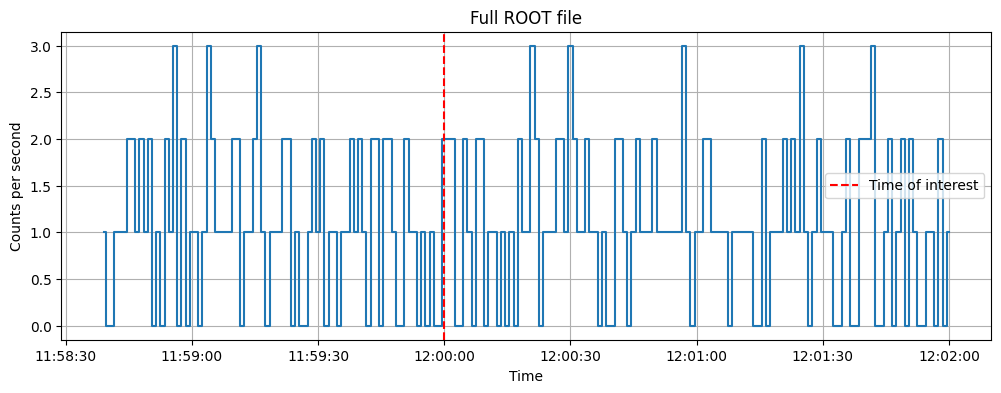

In [ ]:
cps = filtered["Energy"].resample('1s').count()
plt.figure(figsize=(12, 4))
plt.plot(cps, drawstyle='steps-mid')
plt.axvline(time, color='r', linestyle='--', label="Time of interest")
plt.title('Full ROOT file')
plt.xlabel('Time')
plt.ylabel('Counts per second')
plt.legend()
plt.grid(True)
plt.show()

Let's now zoom in on the time period of interest which is around:

In [ ]:
print(time)

2025-09-03 12:00:00


with a duration of:

In [ ]:
duration = pd.to_timedelta(duration, unit='s')
print(duration)

0 days 00:10:00


Once we determine the `start` and `end` times, we can easily pull out cps and waveforms for the burst.

In [ ]:
start = time - duration/2
end = time + duration/2

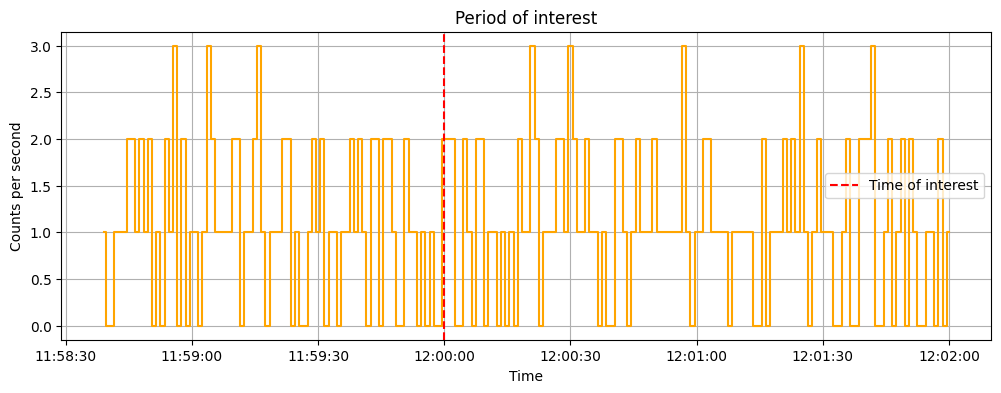

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(cps[start:end], drawstyle='steps-mid', color='orange')
plt.axvline(time, color='r', linestyle='--', label="Time of interest")
plt.title('Period of interest')
plt.xlabel('Time')
plt.ylabel('Counts per second')
plt.legend()
plt.grid(True)
plt.show()

### Visualising the waveforms

We can now easily extract and visualise the waveforms using the `start` and `end` times.

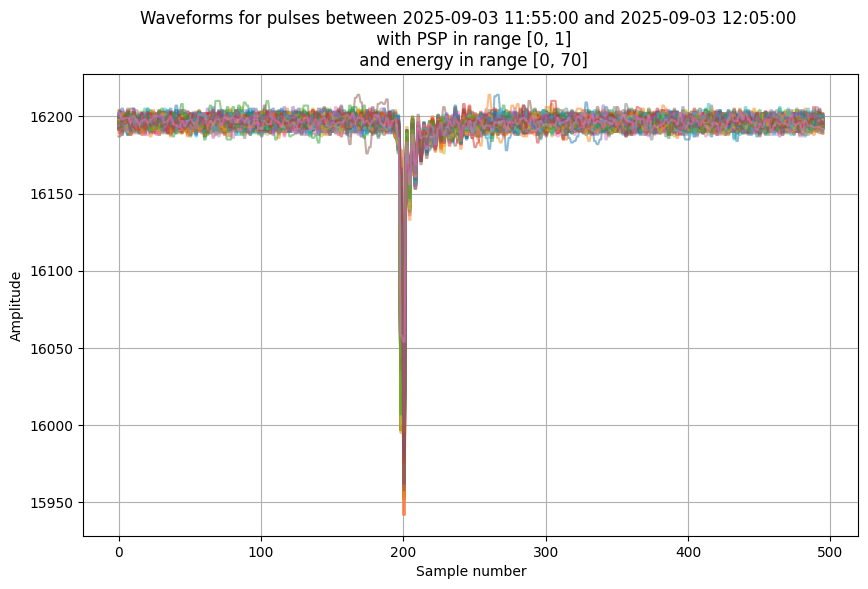

In [ ]:
df_period = filtered[start:end]

plt.figure(figsize=(10, 6))
for wf in df_period['Waveform']:
    plt.plot(wf, alpha=0.5)
plt.title(f'Waveforms for pulses between {start} and {end} \n with PSP in range {psp_range}\n and energy in range {energy_range}')
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()